Starting process...
Data loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1508 entries, 0 to 1507
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Number               1508 non-null   int64  
 1   Name                 1508 non-null   object 
 2   Country              1508 non-null   object 
 3   Region               1508 non-null   object 
 4   Type                 1508 non-null   object 
 5   Activity Evidence    1507 non-null   object 
 6   Last Known Eruption  1508 non-null   object 
 7   Latitude             1508 non-null   float64
 8   Longitude            1508 non-null   float64
 9   Elevation (Meters)   1508 non-null   int64  
 10  Dominant Rock Type   1455 non-null   object 
 11  Tectonic Setting     1501 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 141.5+ KB
Initial Data Info:
 None
Summary Statistics:
               Number     Latitude    

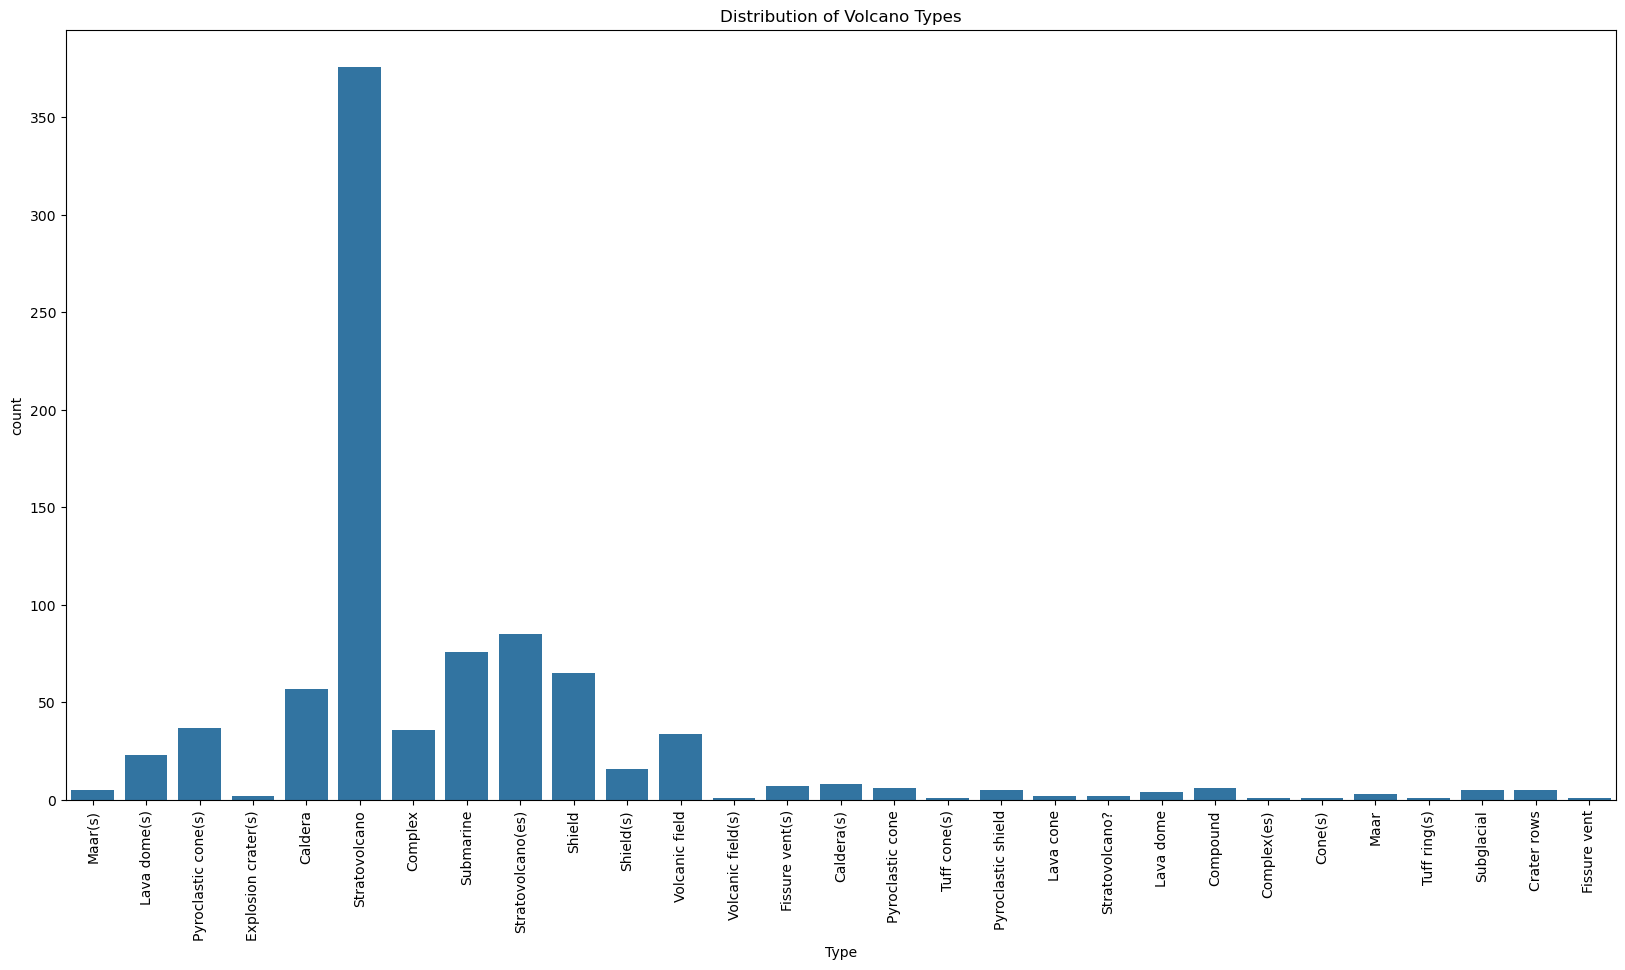

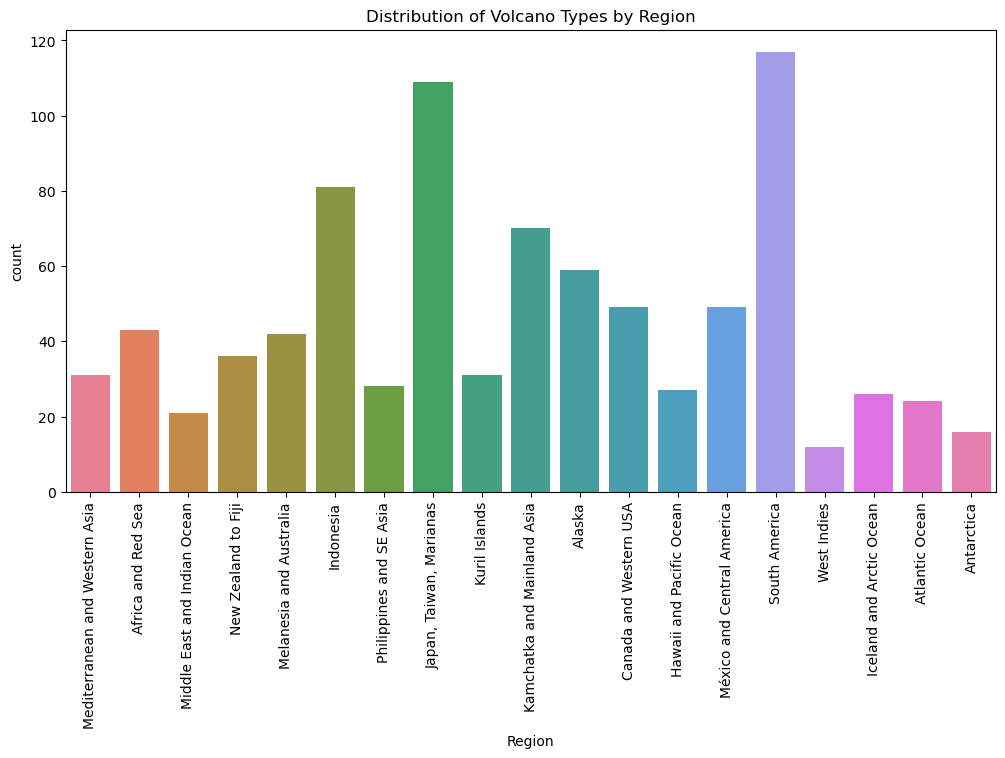

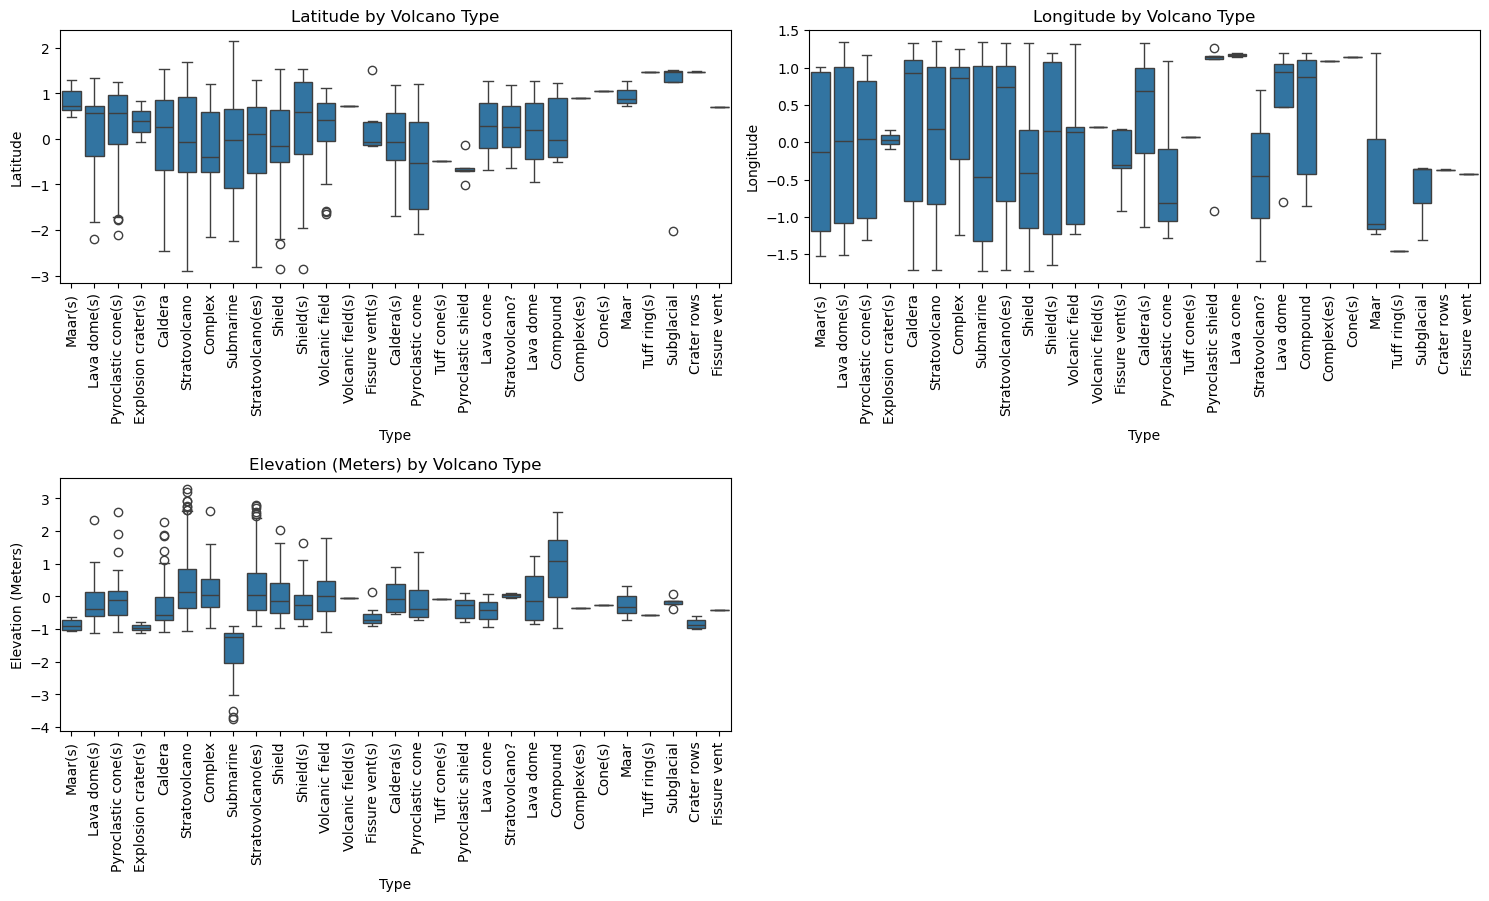

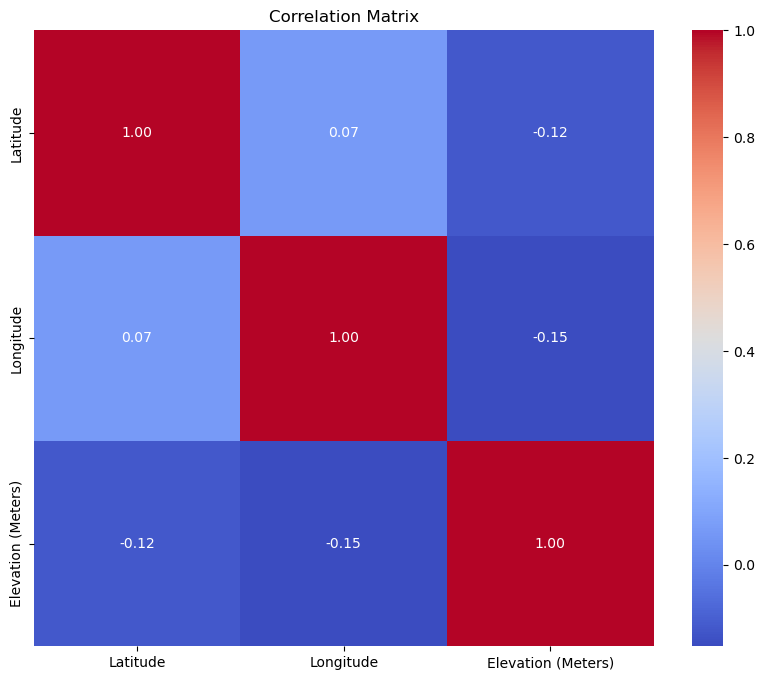

Results for RandomForest:

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        25
           9       0.88      1.00      0.94        15
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         6
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         7
          14       1.00      1.00      1.00        11
          15       1.00      1.00      1.00         6
          16       1.00      0

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

class VolcanoClassifier:
    def __init__(self, filepath, target_column):
        self.filepath = filepath
        self.target_column = target_column
        self.data = None
        self.label_encoders = {}
        self.scaler = None
        self.models = {"RandomForest": None, "LogisticRegression": None}

    def load_data(self):
        self.data = pd.read_csv(self.filepath)
        print("Data loaded successfully.")

    def preprocess_data(self):
        data = self.data

        print("Initial Data Info:\n", data.info())
        print("Summary Statistics:\n", data.describe())

        # Remove unnecessary columns
        columns_to_drop = ['Number', 'Name']
        data = data.drop(columns=[col for col in columns_to_drop if col in data.columns], errors='ignore')

        # Remove rows where 'Last Known Eruption' is 'Unknown'
        data = data[data['Last Known Eruption'] != 'Unknown']

        # missing values
        for column in data.select_dtypes(include=['float64', 'int64']).columns:
            data[column] = data[column].fillna(data[column].mean())

        for column in data.select_dtypes(include=['object']).columns:
            data[column] = data[column].fillna("Unknown")

        # Visualizations
        print("Creating visualizations...")
        plt.figure(figsize=(20, 10))
        sns.countplot(data=data, x='Type')
        plt.xticks(rotation=90)
        plt.title("Distribution of Volcano Types")
        plt.show()

        plt.figure(figsize=(12, 6))
        sns.countplot(data=data, x='Region', hue='Region')
        plt.xticks(rotation=90)
        plt.title("Distribution of Volcano Types by Region")
        plt.show()

        # Normalize numeric data
        numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
        self.scaler = StandardScaler()
        data[numeric_cols] = self.scaler.fit_transform(data[numeric_cols])

        # Box plots for each numeric column
        plt.figure(figsize=(15, 12))
        for i, col in enumerate(numeric_cols):
            plt.subplot(3, 2, i+1)
            sns.boxplot(data=data, x='Type', y=col)
            plt.title(f"{col} by Volcano Type")
            plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

        # Correlation matrix
        numeric_data = data.select_dtypes(include=['float64', 'int64'])
        plt.figure(figsize=(10, 8))
        sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Correlation Matrix")
        plt.show()

        # Encode categorical features
        for column in data.select_dtypes(include=['object']).columns:
            if column == self.target_column:
                continue
            le = LabelEncoder()
            data[column] = le.fit_transform(data[column])
            self.label_encoders[column] = le

        # Encode target column
        target_encoder = LabelEncoder()
        data[self.target_column] = target_encoder.fit_transform(data[self.target_column])
        self.label_encoders[self.target_column] = target_encoder

        self.data = data

    def train_model(self):
        data = self.data
        min_samples = 5
        data = data[data[self.target_column].isin(
            data[self.target_column].value_counts()[data[self.target_column].value_counts() >= min_samples].index
        )]

        # Split data
        X = data.drop(columns=[self.target_column])
        y = data[self.target_column]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Oversampling
        smote = SMOTE(random_state=42, k_neighbors=1) 
        X_train, y_train = smote.fit_resample(X_train, y_train)


# Initialize models
        rf_clf = RandomForestClassifier(random_state=42)
        lr_clf = LogisticRegression(max_iter=10000, solver='liblinear', C=0.1, random_state=42)


        # Hyperparameter tuning for Random Forest
        param_grid = {
            'n_estimators': [100, 200, 300],  
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],  
            'max_features': ['log2', 'sqrt'],
            'bootstrap': [True, False]
        }

        rf_grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, scoring='accuracy')
        rf_grid_search.fit(X_train, y_train)

        # Best Random Forest model
        self.models["RandomForest"] = rf_grid_search.best_estimator_

        # Train Logistic Regression model
        lr_clf.fit(X_train, y_train)
        self.models["LogisticRegression"] = lr_clf

        # Evaluate models
        for model_name, model in self.models.items():
            y_pred = model.predict(X_test)
            print(f"Results for {model_name}:\n")
            print("Classification Report:\n", classification_report(y_test, y_pred))
            print("Accuracy Score:", accuracy_score(y_test, y_pred))
            print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    def run(self):
        print("Starting process...")
        self.load_data()
        self.preprocess_data()
        self.train_model()
        print("Process completed.")

# Main Execution
if __name__ == "__main__":
    filepath = "data/database.csv"
    target_column = "Region"

    classifier = VolcanoClassifier(filepath, target_column)
    classifier.run()
